In [42]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
import dask.async
import dask.diagnostics

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
c = Client("10.114.185.14:8786")

In [3]:
expr_file = "../data/gtex/exprs.npy"
target_file = "../data/gtex/target.csv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10)
signature_generator = GiniSignatureGenerator
signature_tester = BioQCSignatureTester

In [4]:
sig_list, res_list = cross_validate_signatures(expr_file, target_file, signature_generator, signature_tester, splitter)


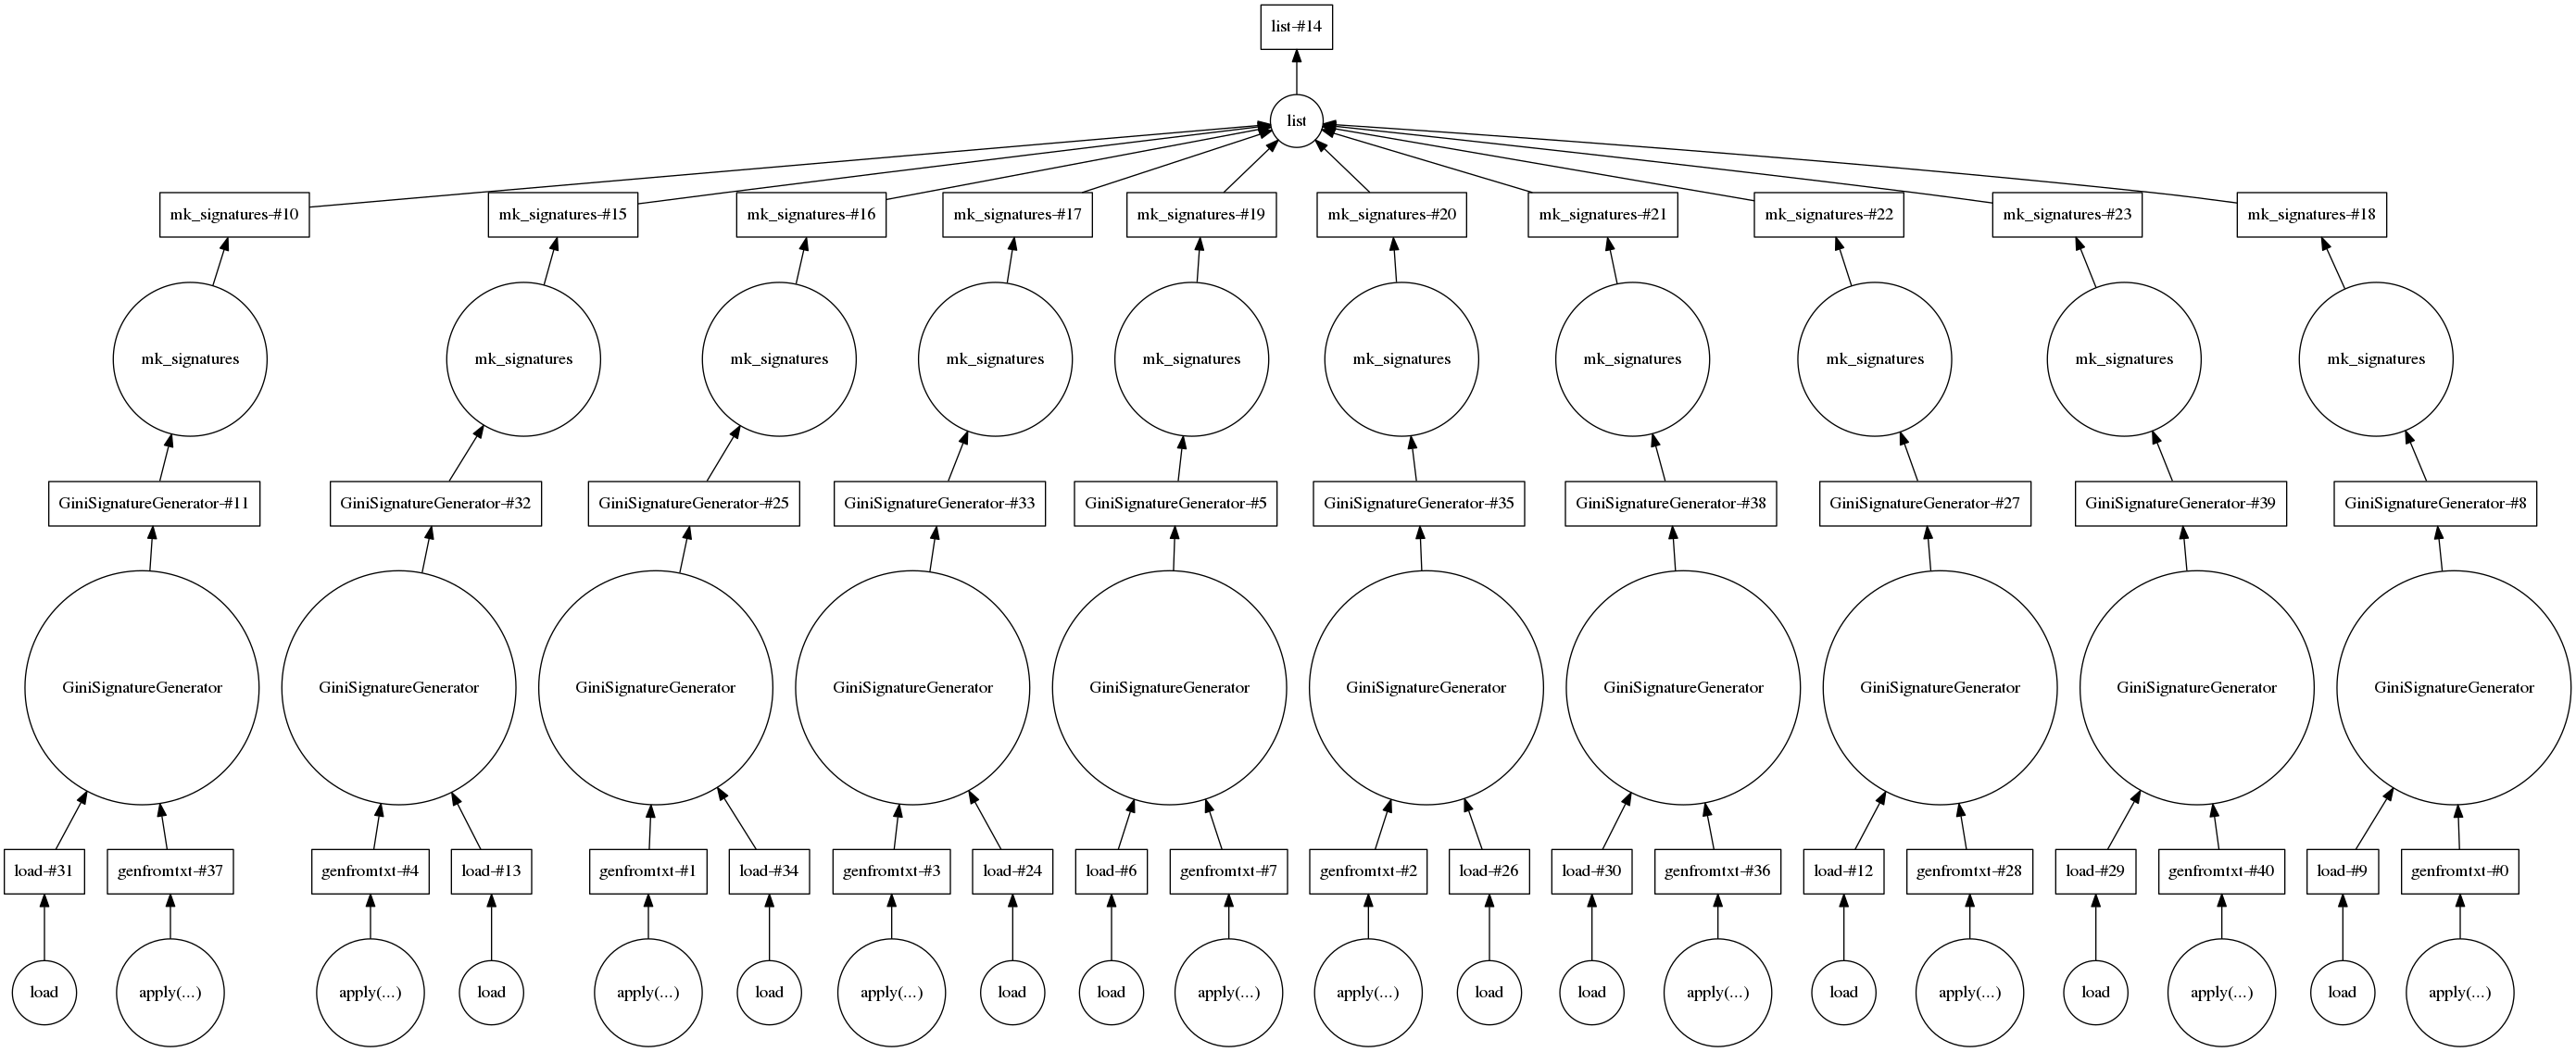

In [5]:
res_list.visualize()

In [6]:
sig_f, res_f = c.compute([sig_list, res_list], sync=False)

In [7]:
progress([sig_f, res_f])

In [11]:
signatures = sig_f.result()

In [12]:
cms = res_f.result()

## Signature overlap between the folds

In [24]:
pairwise_jaccard = pairwise_jaccard_ind(signatures)

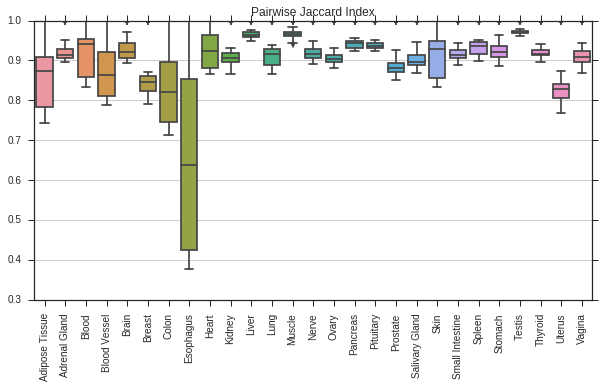

In [25]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(pairwise_jaccard)
sns.boxplot(data=data, ax=ax)
ax.set_title("Pairwise Jaccard Index")
ax.set_xticklabels(data.columns, rotation=90);

## Confusion Matrix

In [27]:
conf_mat_mean = np.mean(np.array(cms), axis=0)

In [32]:
sig_labels = BioQCSignatureTester.sort_signatures(signatures[0])

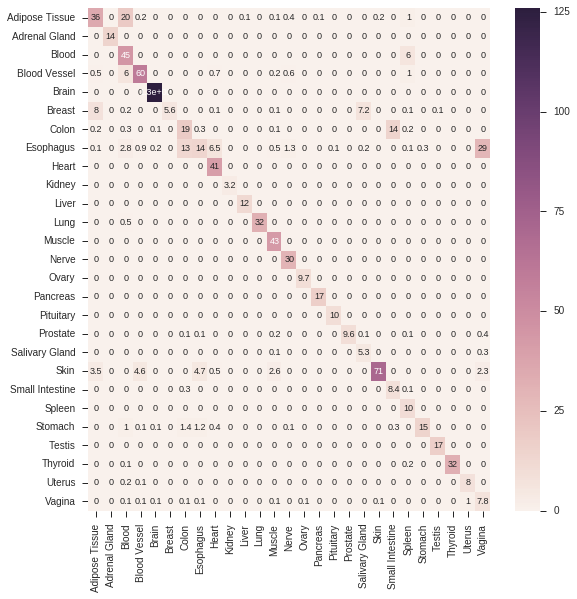

In [39]:
fig, ax = subplots(figsize=(9, 9))
sns.heatmap(conf_mat_mean, ax=ax, xticklabels=sig_labels, yticklabels=sig_labels, annot=True,annot_kws={"size": 9});

## Performance Measures per Tissue

In [43]:
sens = {}
spec = {}
mcc = {}
for i, sig in enumerate(sig_labels):
    sens[sig] = []
    spec[sig] = []
    mcc[sig] = []
    for confmat in cms: 
        TP = confmat[i, i]
        FN = np.sum(confmat[i, :]) - TP
        FP = np.sum(confmat[:, i]) - TP
        TN = np.sum(confmat) - TP - FN - FP
        m = (TP, FN, FP, TN)
        sens[sig].append(pm.sens(*m))
        spec[sig].append(pm.sens(*m))
        mcc[sig].append(pm.mcc(*m))

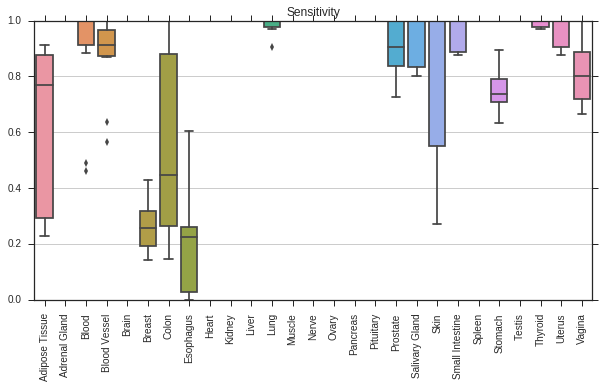

In [44]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(sens)
sns.boxplot(data=data, ax=ax)
ax.set_title("Sensitivity")
ax.set_xticklabels(data.columns, rotation=90);

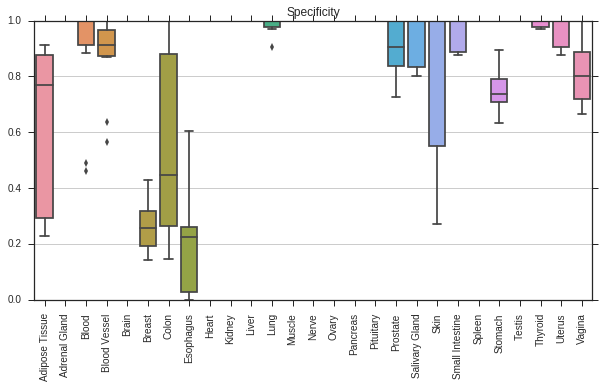

In [46]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(spec)
sns.boxplot(data=data, ax=ax)
ax.set_title("Specificity")
ax.set_xticklabels(data.columns, rotation=90);

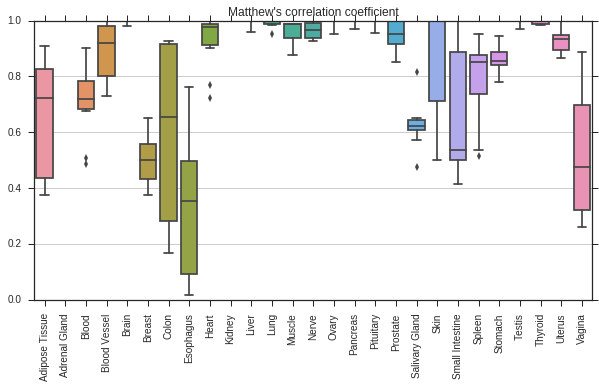

In [47]:
fig, ax = subplots(figsize=(10,5))
data=pd.DataFrame(mcc)
sns.boxplot(data=data, ax=ax)
ax.set_title("Matthew's correlation coefficient")
ax.set_xticklabels(data.columns, rotation=90);